##### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [2]:
# Select product_group_id
product_group_id = 958

In [3]:
# Read file
df = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [4]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information.loc[product_group_id]

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object

In [5]:
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


**Example**: convert a long dataframe to a wide format

In [6]:
df_long = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

In [7]:
df_long

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [8]:
df_wide

,Abcdin,Falabella,Lider,Paris,Ripley,claro,entel,movistar,wom
2020-06-21,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-22,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-23,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-24,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
2020-06-25,NaN,291.085236,NaN,NaN,NaN,209.214955,316.346766,272.891840,229.127627
...,...,...,...,...,...,...,...,...,...
2021-11-05,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-06,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-07,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN
2021-11-08,200.118257,NaN,NaN,NaN,200.118257,NaN,294.514691,191.021559,NaN


In [9]:
# fix random seed for reproducibility
np.random.seed(7)

def get_product_wide(product_group_id, time_series='1'):
    return pd.read_pickle(f"Data/time_series_{time_series}/wide_product_group_id_{product_group_id}")

## Data Visualization

507


<AxesSubplot:>

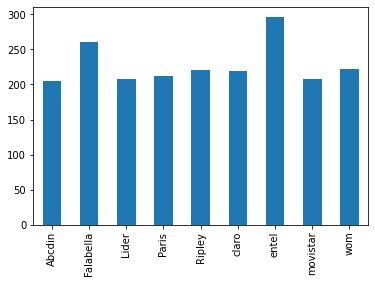

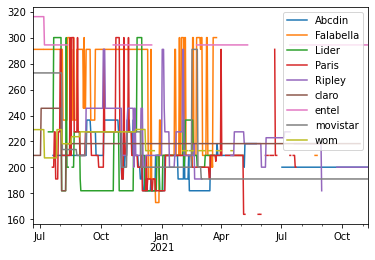

In [10]:
product_group_id = 958
time_series = '1'

df_wide = get_product_wide(product_group_id, time_series=time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
print(len(df_wide))
df_wide.mean().plot(kind='bar')
df_wide.plot()

<AxesSubplot:>

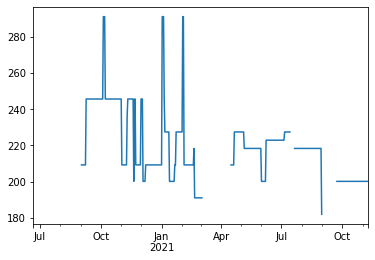

In [11]:
df_wide["Ripley"].plot()

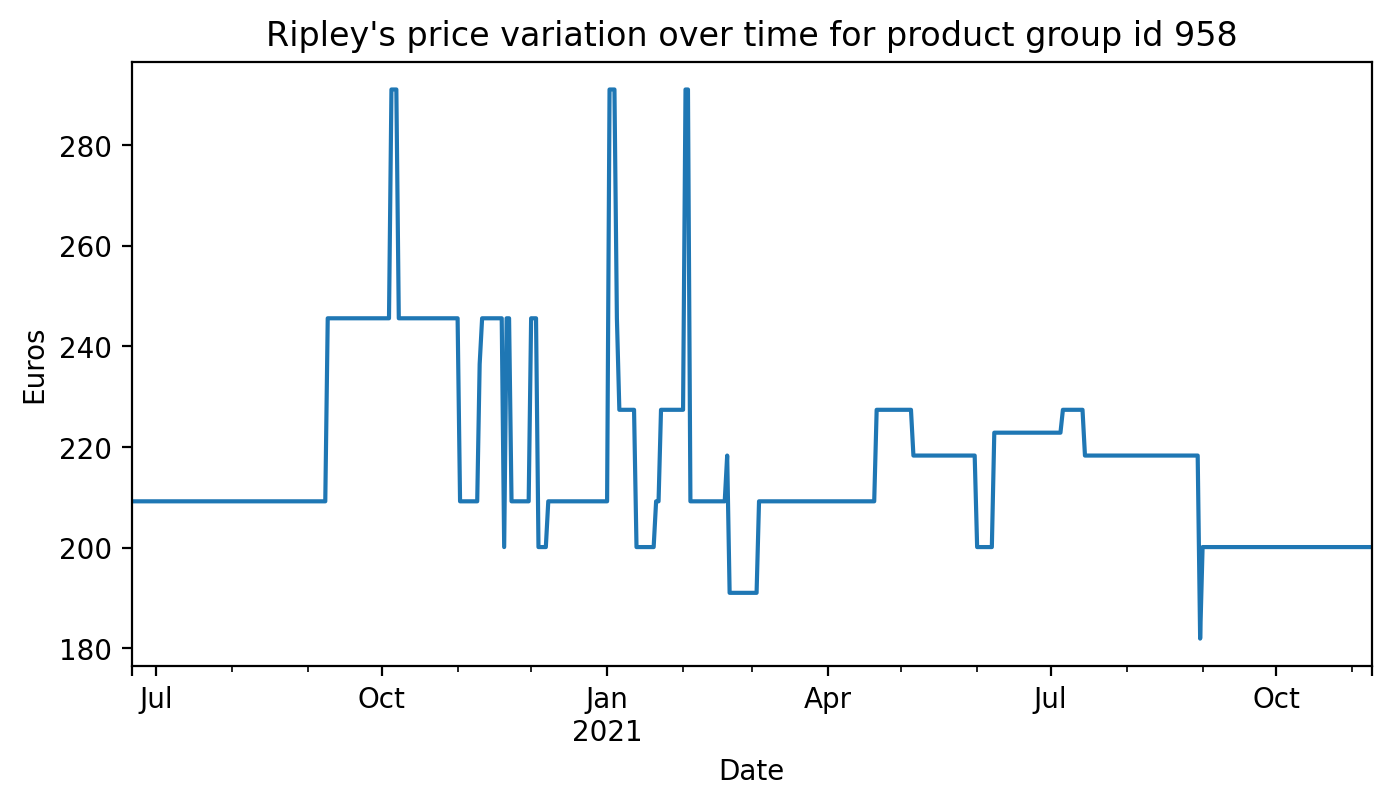

In [12]:
df_wide["Ripley"].fillna(method='bfill', inplace=True)
df_wide["Ripley"].fillna(method='ffill', inplace=True)
plt.figure(figsize=(8, 4), dpi=200)
df_wide["Ripley"].plot()
plt.title(f"Ripley's price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

Abcdin 507
Falabella 507
Lider 507
Paris 507
Ripley 507
claro 507
entel 507
movistar 507
wom 507


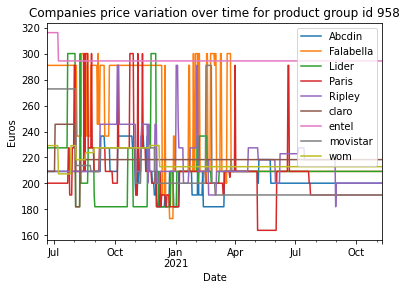

In [13]:
for comp in df_wide.keys():
    df_wide[comp].fillna(method='bfill', inplace=True)
    df_wide[comp].fillna(method='ffill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
plt.title(f"Companies price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

In [14]:
product_group_id = 958
time_series = '1'
company = "Ripley"
n_steps = 8 # number of days
train_split_amount = 0.7

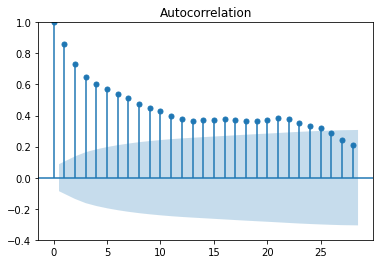

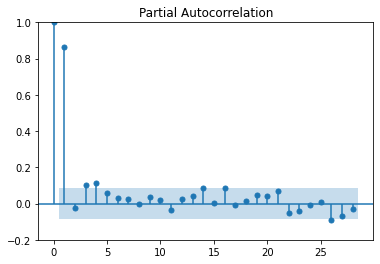

In [15]:
plot_acf(df_wide[company])
plt.ylim(-0.4)
plot_pacf(df_wide[company])
plt.ylim(-0.2)
plt.show()

In [16]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide[company])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.538491168697959
p-value: 0.00016743668356527359


Since the p-value is less than 0.05 we reject the null hypothesis with a high probability.
Meaning that data is stationary.

## Split Training and Test

In [17]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

df_wide = get_product_wide(product_group_id, time_series)
if company in df_wide.keys():
    # DROP NAN VALUES
    df_wide[company].fillna(method='bfill', inplace=True)
    df_wide[company].fillna(method='ffill', inplace=True)
    prices = df_wide[company].values

    # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
    X, y = split_sequence(prices, n_steps)

    # SPLIT INTO TRAIN AND TEST DATA
    train_size = int(len(y) * train_split_amount)
    test_size = len(y) - train_size

    # ADD DATA TO DATASET
    X_train = np.concatenate((X_train, X[0:train_size,:]))
    y_train = np.append(y_train, y[0:train_size])
    X_test = np.concatenate((X_test, X[train_size:,:]))
    y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 8)
(349,)
(150, 8)
(150,)


## Normalizing the data

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

# Univariate Models

In [19]:
# We are working with a univariate series, so the number of features is one, for one variable.
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)
print(X_test.shape)

(349, 8, 1)
(150, 8, 1)


In [20]:
univariate_results = []

In [21]:
# define evaluation metrics
def evaluate_pred(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = str(round(np.sqrt(mse), 4))
    rmsle = str(round(np.log(np.sqrt(mse)), 4))
    mse = str(round(mse, 4))
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adjusted_r2 = str(round(1 - ((1-r2) * ((n-1)/(n-k-1))), 4))
    r2 = str(round(r2, 4))

    table = [
        ["Mean Absolute Error (MAE)", mae],
        ["Mean Squared Error (MSE)", mse],
        ["Root Mean Squared Error (RMSE)", rmse],
        ["Root Mean Squared Log Error (RMSLE)", rmsle],
        ["R Squared (R2)", r2],
        ["Adjusted R Squared (AR2)", adjusted_r2],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    fig = plt.figure(figsize=(6, 4), dpi=200)
    plt.plot(y_test, color='b', label='real data')
    plt.plot(y_pred, color='r', label='predictions on test data')
    plt.title("Product Price Prediction")
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    return [x[1] for x in table]

In [22]:
n_epochs = 50
verbose = 0

# define evaluation strategy
def train_and_test_model(model, n_epochs=50, verbose=0):
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=n_epochs, verbose=verbose)

    # get predictions on test data
    y_pred = model.predict(X_test, verbose=verbose)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss function')
    plt.legend(['train', 'test'])
    plt.xlabel('iterations')

    return y_pred

## Arima

In [23]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_wide[company][:train_size])

result_df

100%|██████████| 64/64 [00:19<00:00,  3.31it/s]


,"(p, d, q)",AIC
0,"(1, 1, 2)",2608.889077
1,"(2, 1, 1)",2608.995932
2,"(3, 1, 1)",2610.730906
3,"(1, 1, 3)",2610.831838
4,"(2, 1, 2)",2610.867835
...,...,...
59,"(7, 1, 6)",2623.850395
60,"(2, 1, 0)",2629.408712
61,"(0, 1, 0)",2636.016885
62,"(0, 1, 1)",2637.484704


In [25]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(1, 1, 2)

                               SARIMAX Results                                
Dep. Variable:                 Ripley   No. Observations:                  349
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1300.445
Date:                Wed, 04 Jan 2023   AIC                           2608.889
Time:                        18:25:18   BIC                           2624.298
Sample:                    06-21-2020   HQIC                          2615.024
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6286      0.065      9.690      0.000       0.501       0.756
ma.L1         -0.7464      0.074    -10.135      0.000      -0.891      -0.602
ma.L2         -0.1547      0.046     -3.356      0.0

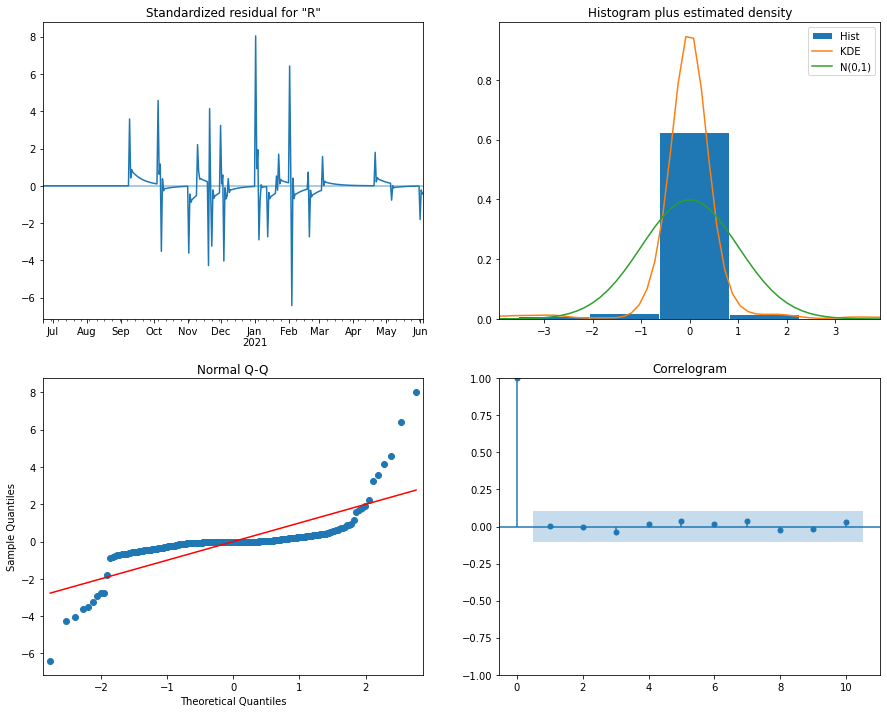

In [26]:
best_model = SARIMAX(df_wide[company][:train_size], order=best_order).fit()
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [27]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 158 next values
2021-06-05    203.587480
2021-06-06    206.342688
2021-06-07    208.074490
2021-06-08    209.163024
2021-06-09    209.847229
                 ...    
2021-11-05    211.005038
2021-11-06    211.005038
2021-11-07    211.005038
2021-11-08    211.005038
2021-11-09    211.005038
Freq: D, Name: predicted_mean, Length: 158, dtype: float64
Statistics of confidence intervals


Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-06-05,203.587480,10.147026,183.699675,223.475285
2021-06-06,206.342688,13.531178,179.822067,232.863308
2021-06-07,208.074490,15.068143,178.541473,237.607507
2021-06-08,209.163024,15.930623,177.939577,240.386472
2021-06-09,209.847229,16.488677,177.530016,242.164443
...,...,...,...,...
2021-11-05,211.005038,37.079530,138.330496,283.679581
2021-11-06,211.005038,37.177796,138.137898,283.872179
2021-11-07,211.005038,37.275803,137.945807,284.064270
2021-11-08,211.005038,37.373553,137.754220,284.255857



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.3591
Mean Squared Error (MSE)             115.477
Root Mean Squared Error (RMSE)        10.746
Root Mean Squared Log Error (RMSLE)    2.3745
R Squared (R2)                         0.0064
Adjusted R Squared (AR2)              -0.0499


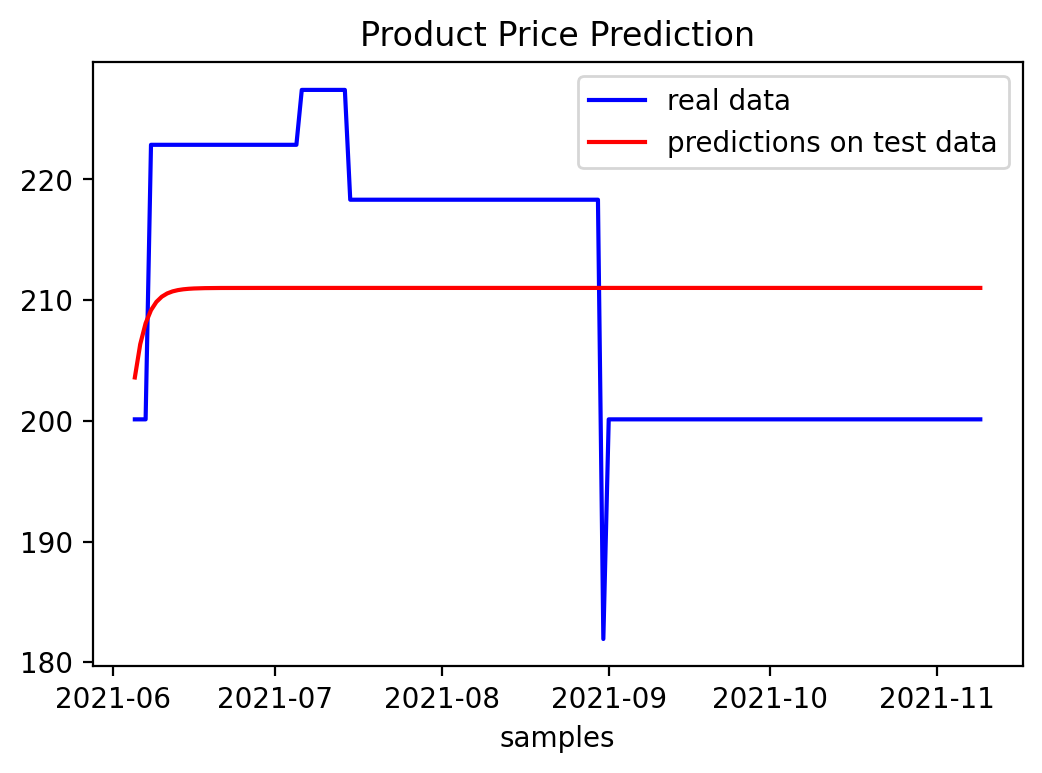

In [28]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "ARIMA")
univariate_results.append(metrics)

## Sarima

In [29]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
        results.append([param, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [30]:
## SARIMA grid of hyperparameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7 # a season was considered to be a week

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, d, D, s, df_wide[company][:train_size])
result_df

256


100%|██████████| 256/256 [05:14<00:00,  1.23s/it]


,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 3)",2579.280258
1,"(2, 1, 3, 3)",2579.508307
2,"(3, 1, 3, 3)",2581.015765
3,"(2, 2, 3, 3)",2581.270353
4,"(1, 3, 3, 3)",2581.343768
...,...,...
251,"(0, 2, 0, 0)",2811.173286
252,"(2, 0, 0, 0)",2812.228362
253,"(0, 0, 0, 0)",2817.637730
254,"(0, 1, 0, 0)",2819.521857


In [31]:
# Choose the values that minimize the AIC score
best_values = result_df[result_df.AIC == result_df.AIC.min()]["(p,q)x(P,Q)"].values[0]
best_order = (best_values[0], d, best_values[1])
print(best_order)
best_seasonal_order = (best_values[2], D, best_values[3], s)
print(best_seasonal_order)

(1, 1, 2)
(3, 1, 3, 7)


                                         SARIMAX Results                                         
Dep. Variable:                                    Ripley   No. Observations:                  349
Model:             SARIMAX(1, 1, 2)x(3, 1, [1, 2, 3], 7)   Log Likelihood               -1279.640
Date:                                   Wed, 04 Jan 2023   AIC                           2579.280
Time:                                           18:36:38   BIC                           2617.599
Sample:                                       06-21-2020   HQIC                          2594.547
                                            - 06-04-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6941      0.056     12.492      0.000    

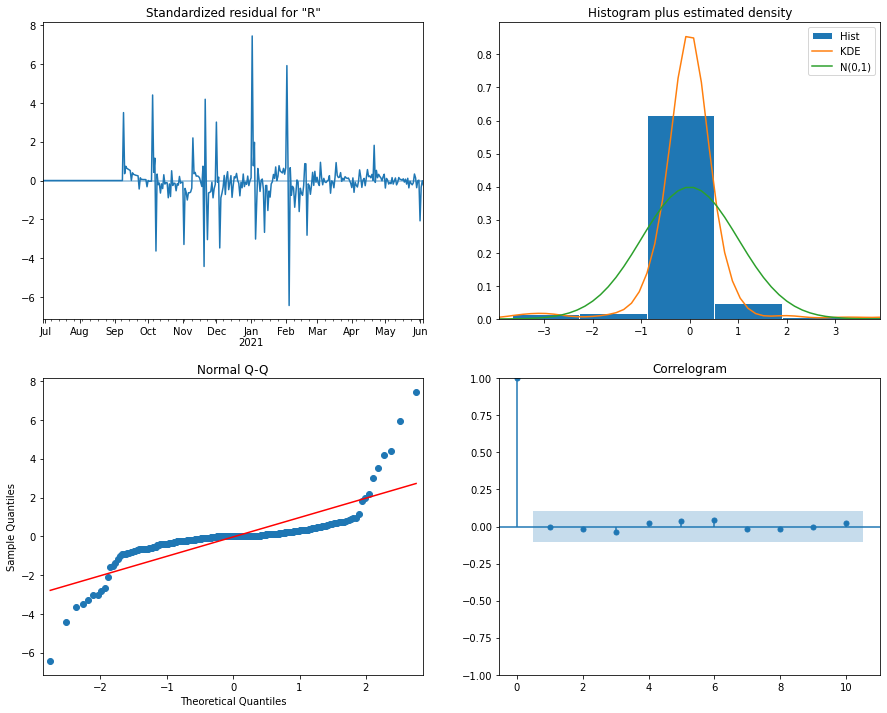

In [60]:
best_model = SARIMAX(df_wide[company][:train_size], order=best_order, seasonal_order=best_seasonal_order).fit(dis=-1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [61]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 158 next values
2021-06-05    202.956320
2021-06-06    205.234119
2021-06-07    205.324722
2021-06-08    206.518021
2021-06-09    207.450561
                 ...    
2021-11-05    209.865250
2021-11-06    212.165776
2021-11-07    212.205018
2021-11-08    211.777914
2021-11-09    212.788027
Freq: D, Name: predicted_mean, Length: 158, dtype: float64
Statistics of confidence intervals


Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-06-05,202.956320,9.947740,183.459107,222.453533
2021-06-06,205.234119,13.357963,179.052994,231.415245
2021-06-07,205.324722,15.032591,175.861386,234.788058
2021-06-08,206.518021,16.005245,175.148316,237.887725
2021-06-09,207.450561,16.631818,174.852797,240.048325
...,...,...,...,...
2021-11-05,209.865250,44.937713,121.788951,297.941549
2021-11-06,212.165776,45.104286,123.762999,300.568553
2021-11-07,212.205018,45.269576,123.478278,300.931757
2021-11-08,211.777914,45.425258,122.746043,300.809784



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.5941
Mean Squared Error (MSE)             124.027
Root Mean Squared Error (RMSE)        11.1368
Root Mean Squared Log Error (RMSLE)    2.4103
R Squared (R2)                        -0.0671
Adjusted R Squared (AR2)              -0.0816


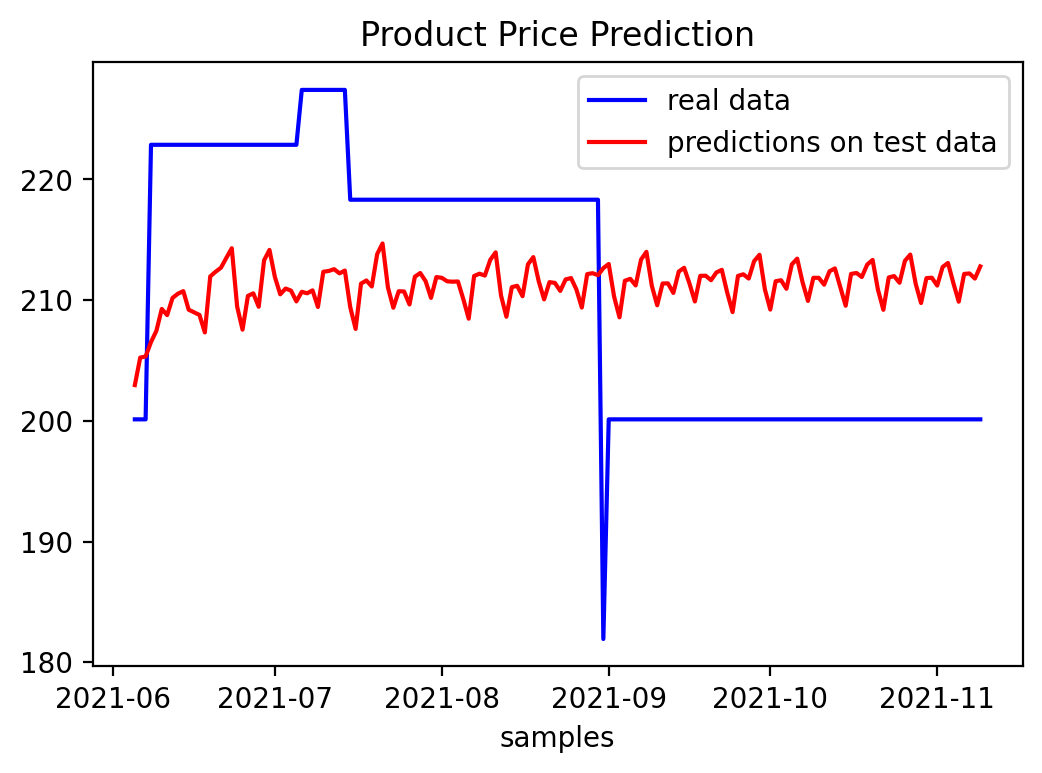

In [62]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "SARIMA")
univariate_results.append(metrics)

## Vanilla LSTM

In [36]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


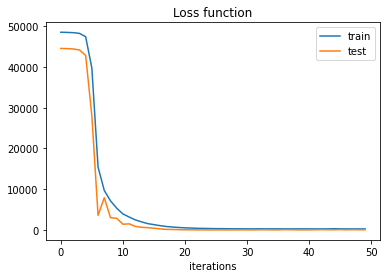

In [37]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             6.3252
Mean Squared Error (MSE)             68.2912
Root Mean Squared Error (RMSE)        8.2638
Root Mean Squared Log Error (RMSLE)   2.1119
R Squared (R2)                        0.4079
Adjusted R Squared (AR2)              0.3743


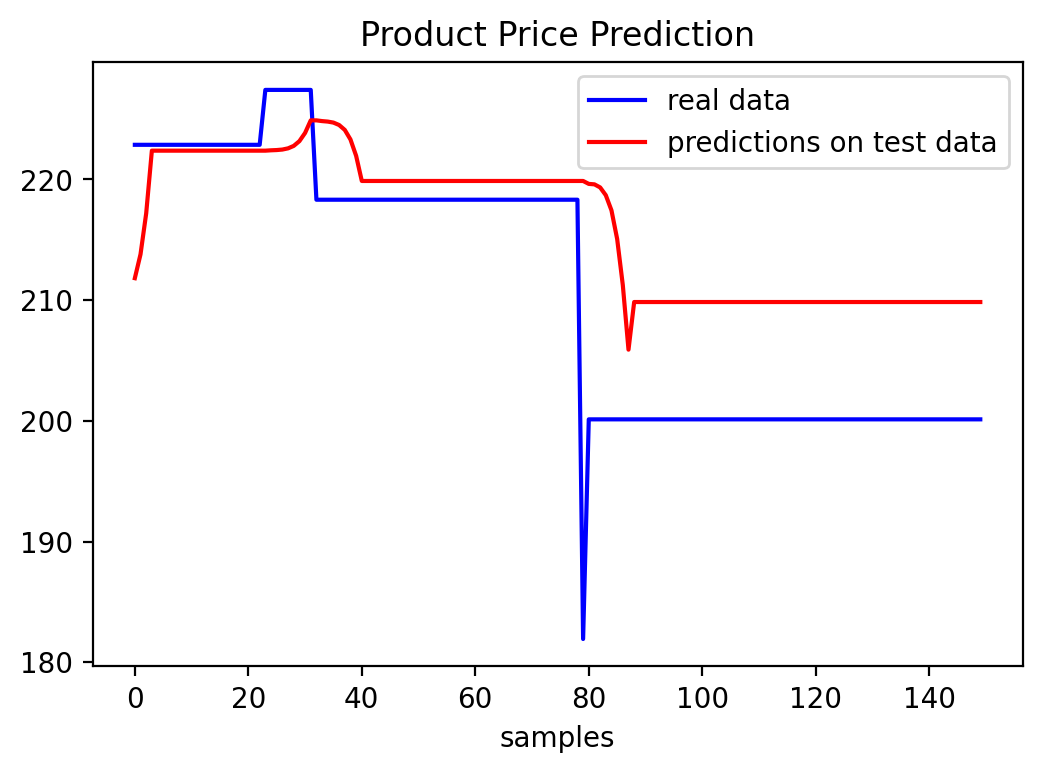

In [38]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
univariate_results.append(metrics)

## Stacked LSTM

In [39]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


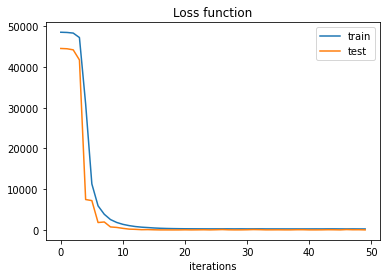

In [40]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             4.8642
Mean Squared Error (MSE)             36.6586
Root Mean Squared Error (RMSE)        6.0546
Root Mean Squared Log Error (RMSLE)   1.8008
R Squared (R2)                        0.6822
Adjusted R Squared (AR2)              0.6641


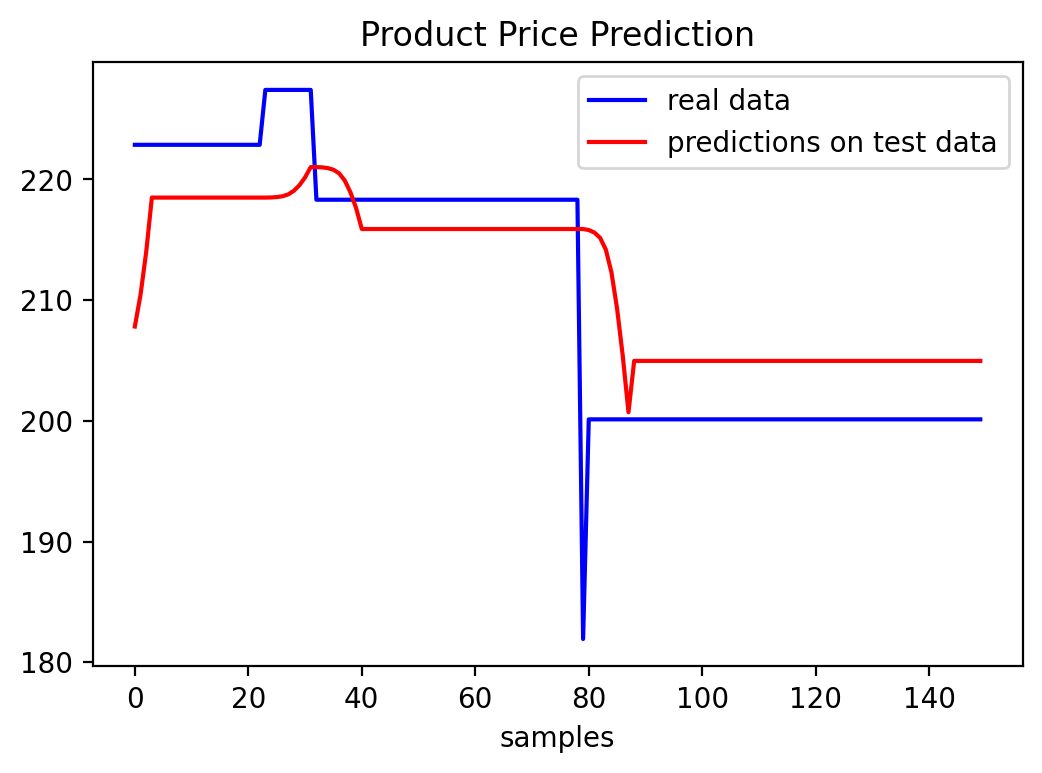

In [41]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
univariate_results.append(metrics)

## Bidirectional LSTM

In [42]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

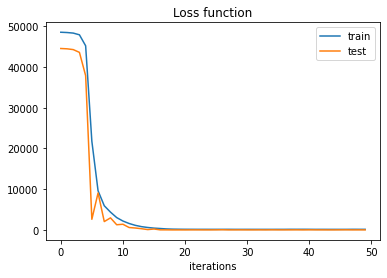

In [43]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             3.4195
Mean Squared Error (MSE)             19.7105
Root Mean Squared Error (RMSE)        4.4396
Root Mean Squared Log Error (RMSLE)   1.4906
R Squared (R2)                        0.8291
Adjusted R Squared (AR2)              0.8194


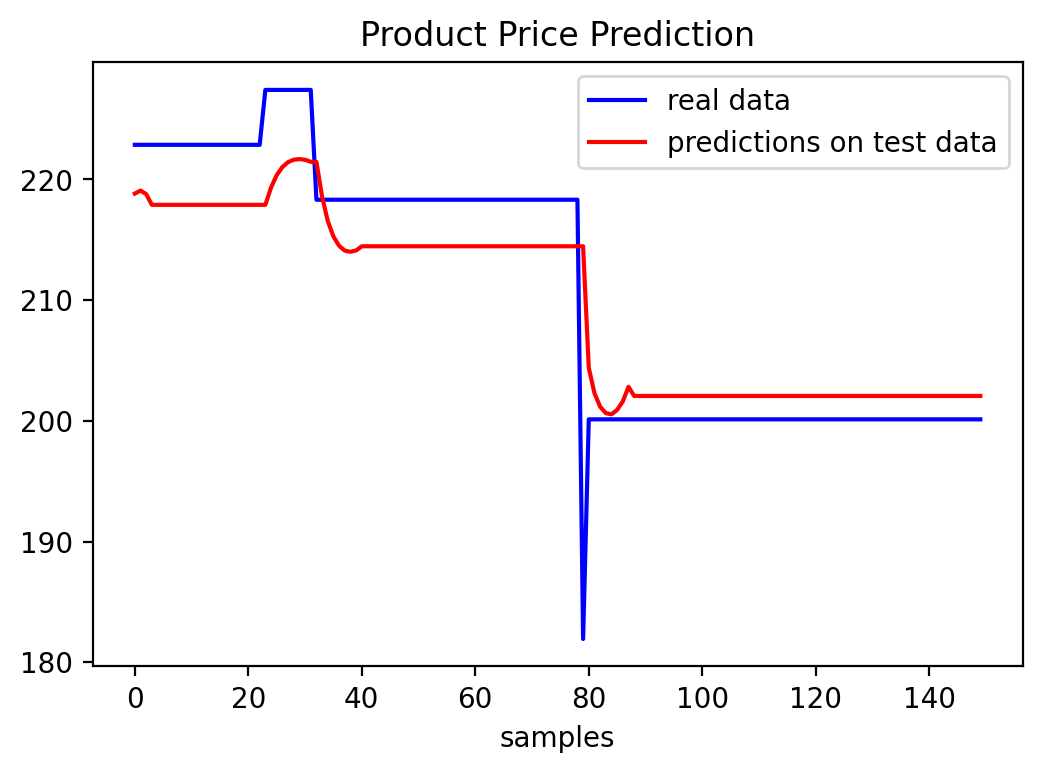

In [44]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
univariate_results.append(metrics)

## CNN LSTM

In [45]:
# reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)


(349, 2, 4, 1)
(150, 2, 4, 1)


In [46]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

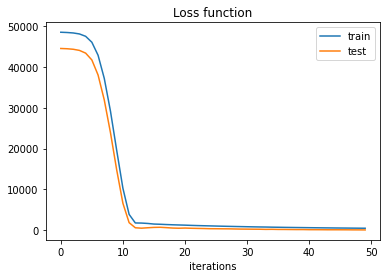

In [47]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             6.2277
Mean Squared Error (MSE)             60.4326
Root Mean Squared Error (RMSE)        7.7738
Root Mean Squared Log Error (RMSLE)   2.0508
R Squared (R2)                        0.476
Adjusted R Squared (AR2)              0.4689


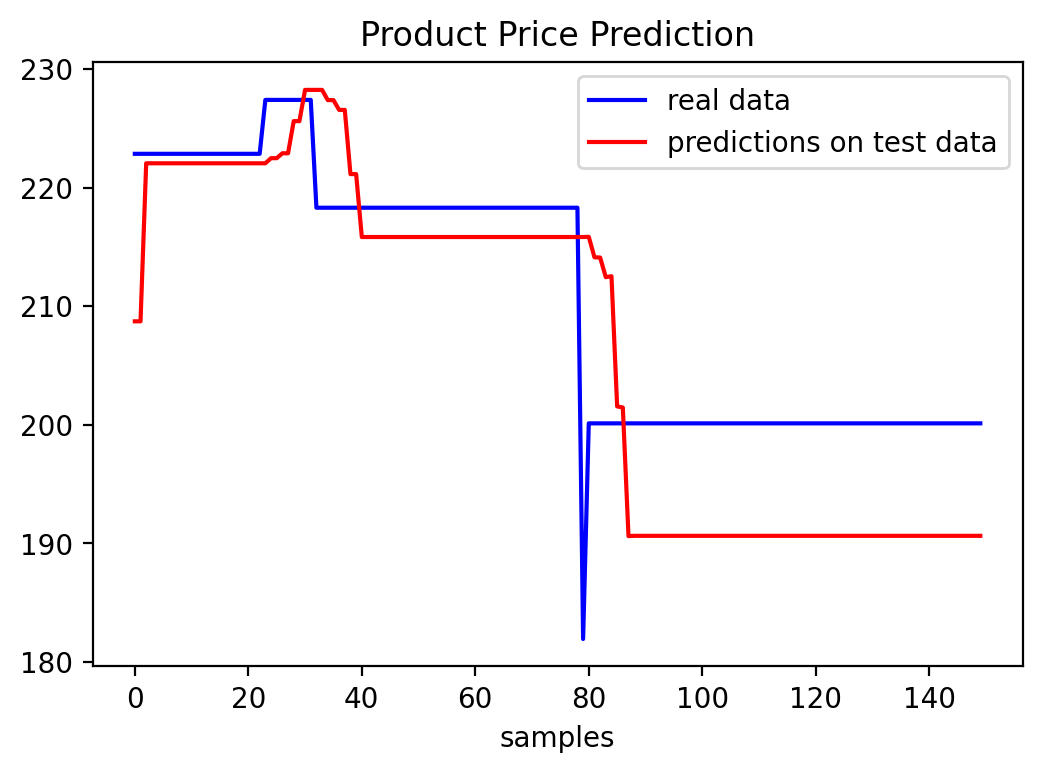

In [48]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
univariate_results.append(metrics)

## ConvLSTM

In [49]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)

(349, 2, 1, 4, 1)
(150, 2, 1, 4, 1)


In [50]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

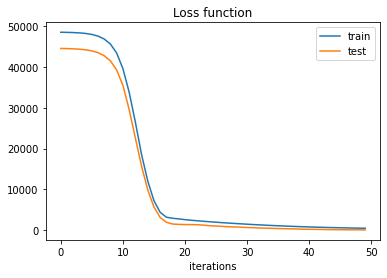

In [51]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             6.4524
Mean Squared Error (MSE)             67.249
Root Mean Squared Error (RMSE)        8.2006
Root Mean Squared Log Error (RMSLE)   2.1042
R Squared (R2)                        0.4169
Adjusted R Squared (AR2)              0.409


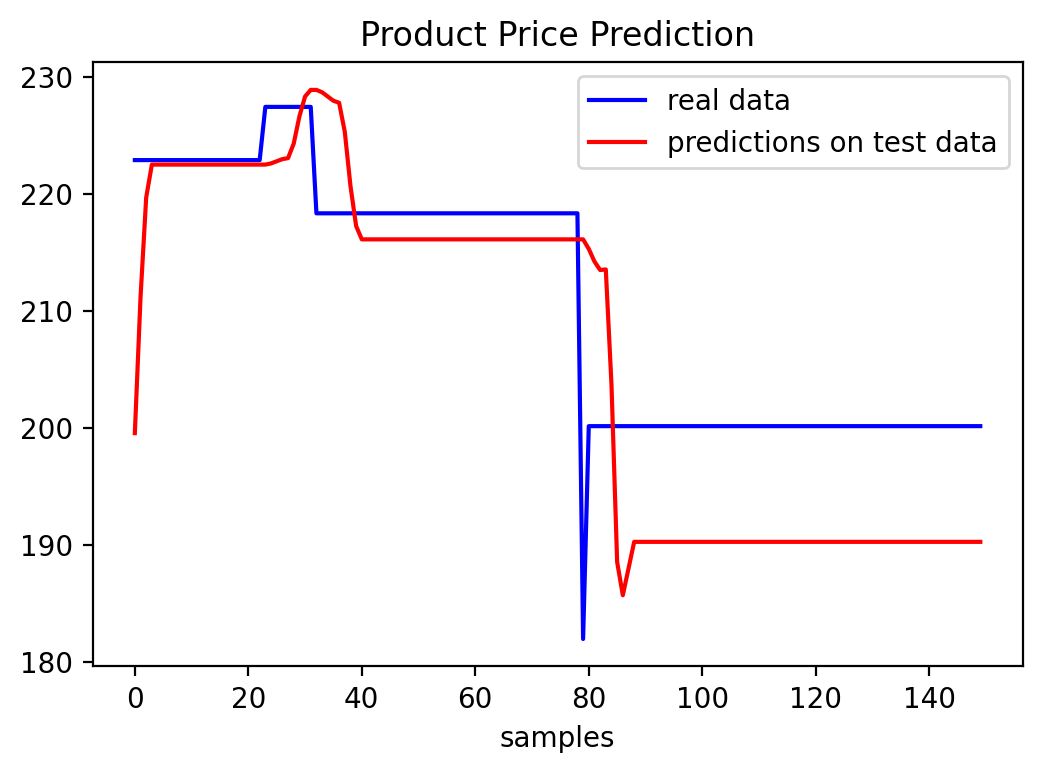

In [52]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
univariate_results.append(metrics)

## Models Results

In [53]:
print(tabulate(univariate_results,
               headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(univariate_results,
         headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )

\begin{tabular}{lrrrrrr}
\toprule
 Univariate Model   &     MAE &      MSE &    RMSE &   RMSLE &      R2 &     AR2 \\
\midrule
 ARIMA              & 10.3591 & 115.477  & 10.746  &  2.3745 &  0.0064 & -0.0499 \\
 SARIMA             & 10.5941 & 124.027  & 11.1368 &  2.4103 & -0.0671 & -0.1277 \\
 Vanilla LSTM       &  6.3252 &  68.2912 &  8.2638 &  2.1119 &  0.4079 &  0.3743 \\
 Stacked LSTM       &  4.8642 &  36.6586 &  6.0546 &  1.8008 &  0.6822 &  0.6641 \\
 Bidirectional LSTM &  3.4195 &  19.7105 &  4.4396 &  1.4906 &  0.8291 &  0.8194 \\
 CNN LSTM           &  6.2277 &  60.4326 &  7.7738 &  2.0508 &  0.476  &  0.4689 \\
 ConvLSTM           &  6.4524 &  67.249  &  8.2006 &  2.1042 &  0.4169 &  0.409  \\
\bottomrule
\end{tabular}


Univariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
ARIMA,10.3591,115.477,10.746,2.3745,0.0064,-0.0499
SARIMA,10.5941,124.027,11.1368,2.4103,-0.0671,-0.1277
Vanilla LSTM,6.3252,68.2912,8.2638,2.1119,0.4079,0.3743
Stacked LSTM,4.8642,36.6586,6.0546,1.8008,0.6822,0.6641
Bidirectional LSTM,3.4195,19.7105,4.4396,1.4906,0.8291,0.8194
CNN LSTM,6.2277,60.4326,7.7738,2.0508,0.476,0.4689
ConvLSTM,6.4524,67.249,8.2006,2.1042,0.4169,0.409


# Multivariate Models

Abcdin 507
Falabella 507
Lider 507
Paris 507
Ripley 507
claro 507
entel 507
movistar 507
wom 507


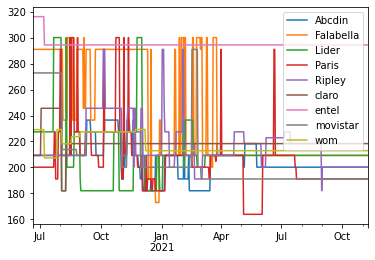

In [ ]:
df_wide = get_product_wide(product_group_id, time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
for comp in df_wide.keys():
    df_wide[comp].fillna(method='bfill', inplace=True)
    df_wide[comp].fillna(method='ffill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
n_days = len(df_wide)
n_companies = len(df_wide.keys())
company = "Ripley"

In [ ]:
X_train = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_train = np.empty(shape=[0], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_test = np.empty(shape=[0], dtype=np.float32)

X, y = list(), list()

# GET PRICES DATA OF THAT COMPANY
prices = df_wide[company].values

for i in range(n_days):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > n_days-1:
        break
    seq_x = []
    # gather input of the pattern from all companies
    for j in range(i, end_ix):
        temp_seq = []
        for comp in df_wide.keys():
            temp_seq.append(df_wide[comp].values[j])
        seq_x.append(temp_seq)
    # gather the output parts of the chosen company
    y.append(prices[end_ix])
    X.append(seq_x)

X, y = np.array(X), np.array(y)

# SPLIT INTO TRAIN AND TEST DATA
train_size = int(len(y) * train_split_amount)
test_size = len(y) - train_size

# ADD DATA TO DATASET
X_train = np.concatenate((X_train, X[0:train_size,:]))
y_train = np.append(y_train, y[0:train_size])
X_test = np.concatenate((X_test, X[train_size:,:]))
y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 8, 9)
(349,)
(150, 8, 9)
(150,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

(349, 72)
(150, 72)


## Normalize Features

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [132]:
X_train = X_train.reshape(X_train.shape[0], n_steps, n_companies)
X_test = X_test.reshape(X_test.shape[0], n_steps, n_companies)

print(X_train.shape)
print(X_test.shape)

(349, 8, 9)
(150, 8, 9)


In [133]:
multivariate_results = []

## Vanilla LSTM

In [134]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                12000     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


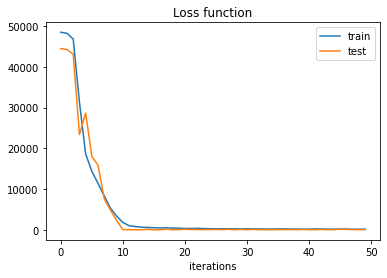

In [135]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             7.9064
Mean Squared Error (MSE)             98.4098
Root Mean Squared Error (RMSE)        9.9202
Root Mean Squared Log Error (RMSLE)   2.2946
R Squared (R2)                        0.1468
Adjusted R Squared (AR2)              0.0983


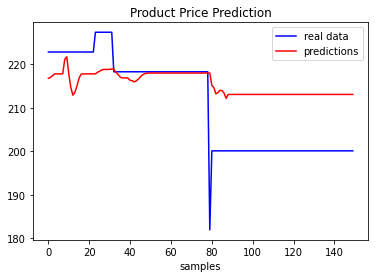

In [136]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
multivariate_results.append(metrics)

## Stacked LSTM

In [137]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_companies)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 8, 50)             12000     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


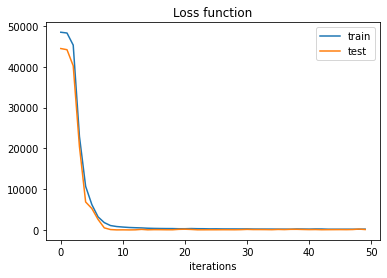

In [138]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              8.6547
Mean Squared Error (MSE)             123.659
Root Mean Squared Error (RMSE)        11.1202
Root Mean Squared Log Error (RMSLE)    2.4088
R Squared (R2)                        -0.0722
Adjusted R Squared (AR2)              -0.133


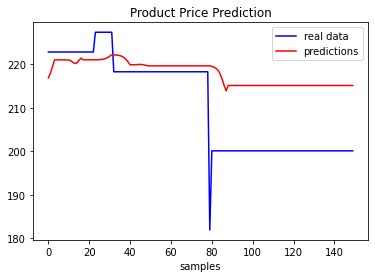

In [139]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
multivariate_results.append(metrics)

## Bidirectional LSTM

In [140]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

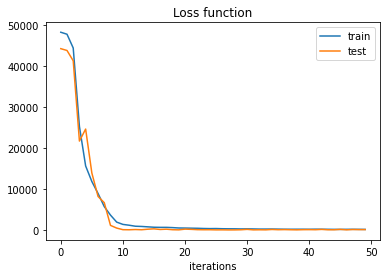

In [141]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              8.2801
Mean Squared Error (MSE)             110.763
Root Mean Squared Error (RMSE)        10.5244
Root Mean Squared Log Error (RMSLE)    2.3537
R Squared (R2)                         0.0397
Adjusted R Squared (AR2)              -0.0148


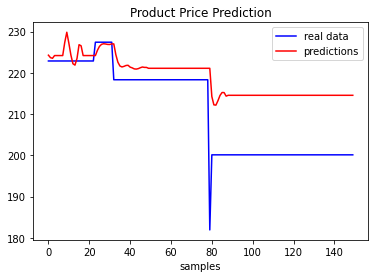

In [142]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
multivariate_results.append(metrics)

## CNN LSTM

In [143]:
# reshape from [samples, timesteps, companies] into [samples, subsequences, timesteps, companies]
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)


(349, 2, 4, 9)
(150, 2, 4, 9)


In [144]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_companies)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

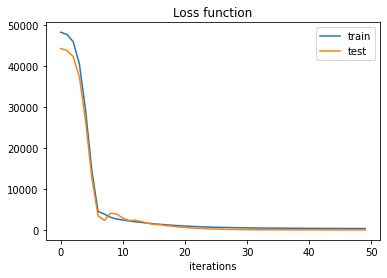

In [145]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             4.648
Mean Squared Error (MSE)             37.6325
Root Mean Squared Error (RMSE)        6.1345
Root Mean Squared Log Error (RMSLE)   1.8139
R Squared (R2)                        0.6737
Adjusted R Squared (AR2)              0.6693


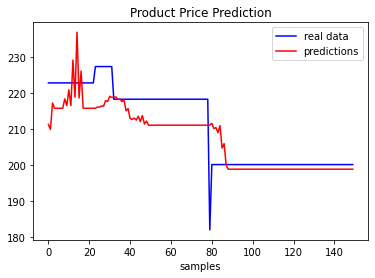

In [146]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
multivariate_results.append(metrics)

## ConvLSTM

In [147]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)

(349, 2, 1, 4, 9)
(150, 2, 1, 4, 9)


In [148]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_companies)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

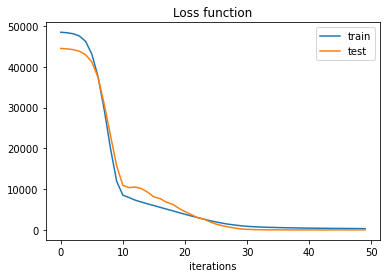

In [149]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             3.8928
Mean Squared Error (MSE)             31.4672
Root Mean Squared Error (RMSE)        5.6096
Root Mean Squared Log Error (RMSLE)   1.7245
R Squared (R2)                        0.7272
Adjusted R Squared (AR2)              0.7235


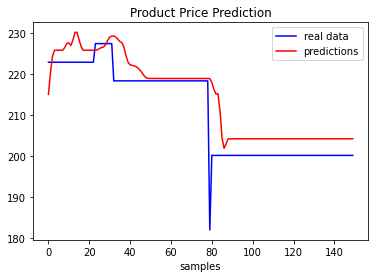

In [150]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
multivariate_results.append(metrics)

## Models Results

In [151]:
print(tabulate(multivariate_results,
               headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(multivariate_results,
         headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )


\begin{tabular}{lrrrrrr}
\toprule
 Multivariate Model   &    MAE &      MSE &    RMSE &   RMSLE &      R2 &     AR2 \\
\midrule
 Vanilla LSTM         & 7.9064 &  98.4098 &  9.9202 &  2.2946 &  0.1468 &  0.0983 \\
 Stacked LSTM         & 8.6547 & 123.659  & 11.1202 &  2.4088 & -0.0722 & -0.133  \\
 Bidirectional LSTM   & 8.2801 & 110.763  & 10.5244 &  2.3537 &  0.0397 & -0.0148 \\
 CNN LSTM             & 4.648  &  37.6325 &  6.1345 &  1.8139 &  0.6737 &  0.6693 \\
 ConvLSTM             & 3.8928 &  31.4672 &  5.6096 &  1.7245 &  0.7272 &  0.7235 \\
\bottomrule
\end{tabular}


Multivariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
Vanilla LSTM,7.9064,98.4098,9.9202,2.2946,0.1468,0.0983
Stacked LSTM,8.6547,123.659,11.1202,2.4088,-0.0722,-0.133
Bidirectional LSTM,8.2801,110.763,10.5244,2.3537,0.0397,-0.0148
CNN LSTM,4.648,37.6325,6.1345,1.8139,0.6737,0.6693
ConvLSTM,3.8928,31.4672,5.6096,1.7245,0.7272,0.7235


# ARIMA